# Load libraries and data

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle
import os
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, cross_val_score
import xgboost as xgb
from google.colab import drive

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_df = pd.read_csv('/content/drive/MyDrive/train_data_processed.csv')
test_df = pd.read_csv('/content/drive/MyDrive/test_data_processed.csv')

In [4]:
X = train_df.drop('isFraud', axis=1)
y = train_df['isFraud']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train simple base model

In [5]:
xgb_clf = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

## Results analysis

In [6]:
y_pred_train = xgb_clf.predict(X_train)
y_pred_val = xgb_clf.predict(X_val)

print(f'Train accuracy: {round(accuracy_score(y_train, y_pred_train), 4)}')
print(f'Validation accuracy: {round(accuracy_score(y_val, y_pred_val), 4)}')

Train accuracy: 0.982
Validation accuracy: 0.9796


In [7]:
print(f'Classification report: \n\n{classification_report(y_val, y_pred_val, digits=4)}')

Classification report: 

              precision    recall  f1-score   support

           0     0.9811    0.9981    0.9895    170963
           1     0.8992    0.4706    0.6178      6199

    accuracy                         0.9796    177162
   macro avg     0.9402    0.7343    0.8037    177162
weighted avg     0.9783    0.9796    0.9765    177162



Validation AUC: 0.9349


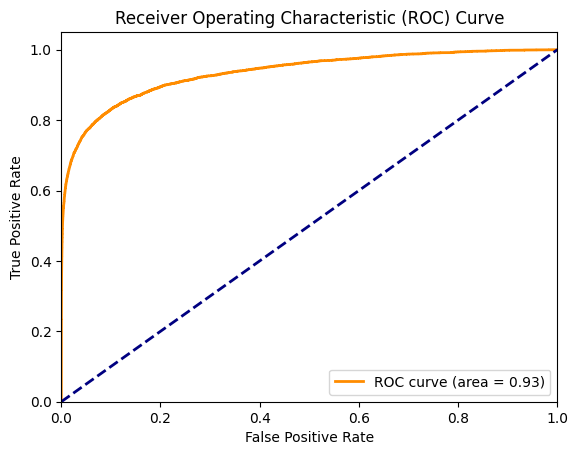

In [8]:
val_proba = xgb_clf.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, val_proba)
roc_auc = auc(fpr, tpr)

print(f"Validation AUC: {round(roc_auc, 4)}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## Most important features

Top 50 Feature ranking:

1. card1 (0.09656520932912827)
2. card3 (0.09372825175523758)
3. addr2 (0.07325498014688492)
4. card2 (0.0687955766916275)
5. addr1 (0.061857156455516815)
6. C3 (0.061189375817775726)
7. card5 (0.05911005288362503)
8. C11 (0.044803325086832047)
9. C7 (0.03911551460623741)
10. C9 (0.033296599984169006)
11. C4 (0.03172004595398903)
12. V12 (0.03170790523290634)
13. D1 (0.03147527948021889)
14. C1 (0.029146725311875343)
15. C6 (0.027300864458084106)
16. D10 (0.02543354593217373)
17. C5 (0.024529315531253815)
18. C14 (0.024504950270056725)
19. C10 (0.02359262853860855)
20. C2 (0.022887403145432472)
21. C13 (0.022582413628697395)
22. D4 (0.02165614627301693)
23. C8 (0.020689288154244423)
24. D15 (0.018997130915522575)
25. C12 (0.01206026691943407)



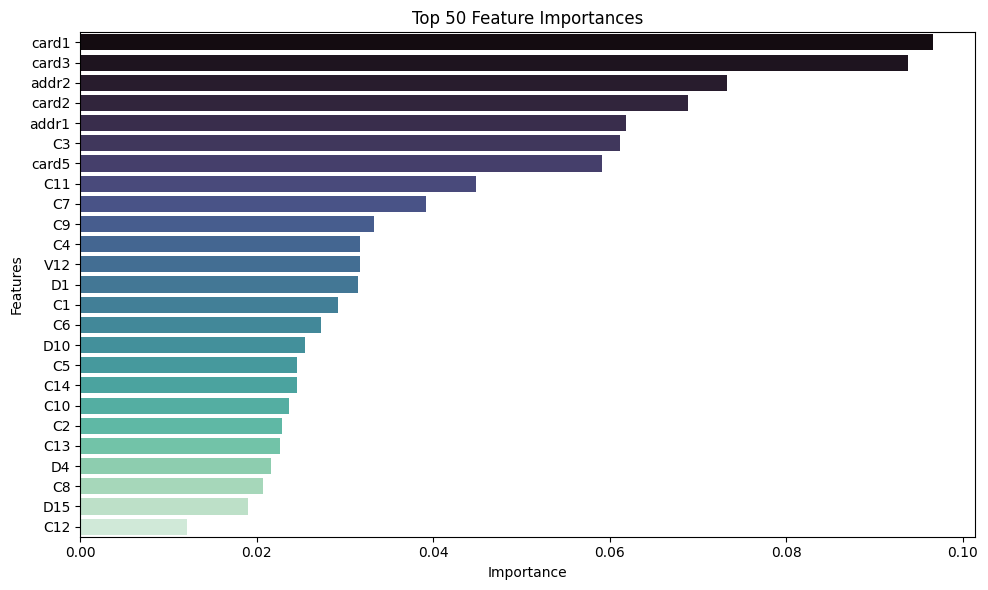

In [21]:
importances = xgb_clf.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])]
n_features = min(50, len(feature_names))

indices = np.argsort(importances)[::-1][:n_features]

print(f"Top {n_features} Feature ranking:\n")
for i in range(len(indices)):
    print(f"{i + 1}. {feature_names[indices[i]]} ({importances[indices[i]]})")
print('')

top_features = [feature_names[i] for i in indices]
top_importances = importances[indices]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_features, palette="mako", legend=False, hue=top_features)
plt.title(f"Top {n_features} Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

Reduce the features to be used to reduce the model complexity

In [22]:
X_important_train = X_train[top_features]
X_important_val = X_val[top_features]

In [23]:
xgb_clf = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
xgb_clf.fit(X_important_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [24]:
y_pred_train = xgb_clf.predict(X_important_train)
y_pred_val = xgb_clf.predict(X_important_val)

print(f'Train accuracy: {round(accuracy_score(y_train, y_pred_train), 4)}')
print(f'Validation accuracy: {round(accuracy_score(y_val, y_pred_val), 4)}')

Train accuracy: 0.98
Validation accuracy: 0.9784


In [25]:
print(f'Classification report: \n\n{classification_report(y_val, y_pred_val, digits=4)}')

Classification report: 

              precision    recall  f1-score   support

           0     0.9798    0.9981    0.9889    170963
           1     0.8944    0.4330    0.5835      6199

    accuracy                         0.9784    177162
   macro avg     0.9371    0.7156    0.7862    177162
weighted avg     0.9768    0.9784    0.9747    177162



Validation AUC: 0.9309


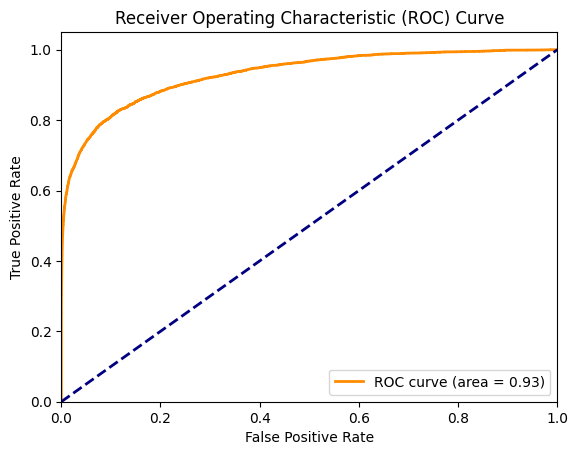

In [26]:
val_proba = xgb_clf.predict_proba(X_important_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, val_proba)
roc_auc = auc(fpr, tpr)

print(f"Validation AUC: {round(roc_auc, 4)}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# Hyperparameter tuning

In [27]:
clf =  xgb.XGBClassifier(eval_metric='logloss', random_state=42)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': range(3, 16, 3),
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3, 0.5, 0.7, 0.9, 1.0],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 1, 10],
    'reg_lambda': [0.01, 0.1, 1, 10, 100],
    'n_estimators': [100, 200, 500, 1000]
}

random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, n_iter=25, cv=3, scoring='roc_auc', verbose=3, random_state=50, n_jobs=-1)

random_search.fit(X_important_train, y_train)

print("Best parameters found: ", random_search.best_params_)
print("Best Roc AUC score: ", random_search.best_score_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters found:  {'subsample': 0.6, 'reg_lambda': 0.1, 'reg_alpha': 1, 'n_estimators': 1000, 'min_child_weight': 3, 'max_depth': 15, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.9}
Best Roc AUC score:  0.9473429776853579


In [30]:
best_params = random_search.best_params_

best_clf = xgb.XGBClassifier(**best_params, eval_metric='logloss', random_state=50)
best_clf.fit(X_important_train, y_train)

scores = cross_val_score(best_clf, X_important_val, y_val, cv=3, scoring='roc_auc')
print("ROC AUC scores from cross-validation: ", scores)
print("Mean ROC AUC score: ", scores.mean())

ROC AUC scores from cross-validation:  [0.92317878 0.92177224 0.92008564]
Mean ROC AUC score:  0.921678885564511


In [31]:
y_pred_train = best_clf.predict(X_important_train)
y_pred_val = best_clf.predict(X_important_val)

print(f'Train accuracy: {round(accuracy_score(y_train, y_pred_train), 4)}')
print(f'Validation accuracy: {round(accuracy_score(y_val, y_pred_val), 4)}')

Train accuracy: 0.994
Validation accuracy: 0.9854


# Evaluación del modelo

In [32]:
print(f'Classification report: \n\n{classification_report(y_val, y_pred_val, digits=4)}')

Classification report: 

              precision    recall  f1-score   support

           0     0.9872    0.9979    0.9925    170963
           1     0.9169    0.6424    0.7555      6199

    accuracy                         0.9854    177162
   macro avg     0.9520    0.8201    0.8740    177162
weighted avg     0.9847    0.9854    0.9842    177162



Validation AUC: 0.9587


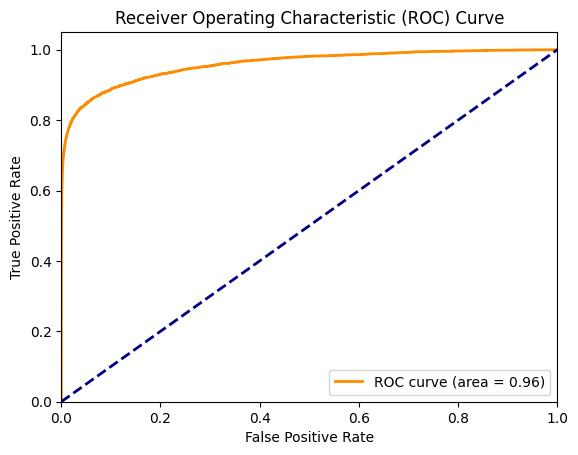

In [33]:
val_proba = best_clf.predict_proba(X_important_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, val_proba)
roc_auc = auc(fpr, tpr)

print(f"Validation AUC: {round(roc_auc, 4)}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


The ROC AUC score achieved of 0.96 shows that the model have a good performance classifying the data correctly in its corresponding class. 

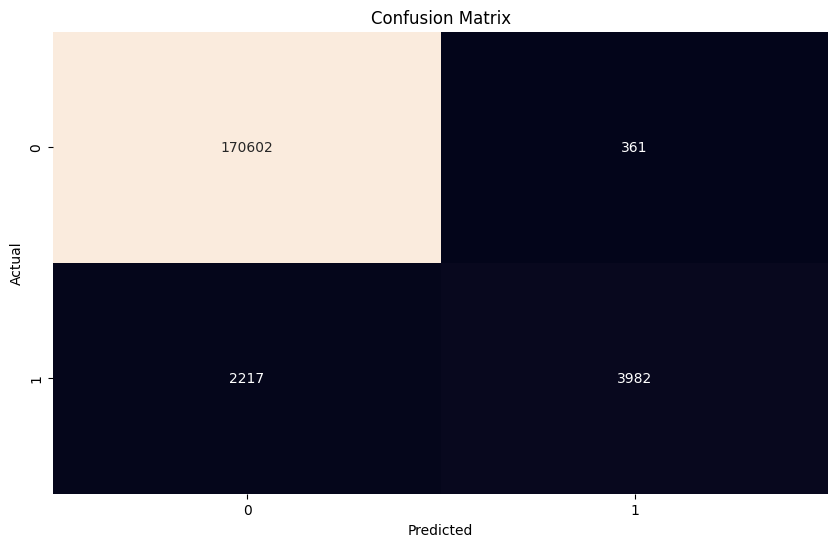

In [34]:
cm = confusion_matrix(y_val, y_pred_val)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The model have a strong ability to correctly identify non-fraudulent transactions and maintain a high precision. 

In [36]:
X_test = test_df[top_features + ['TransactionID']]

In [37]:
start_time = time.time()
test_predictions = best_clf.predict(X_test.drop(columns=['TransactionID']))
end_time = time.time()

inference_time = end_time - start_time
print(f"Inference time: {inference_time:.6f} seconds")

Inference time: 52.975958 seconds


In [40]:
model_filename = 'xgboost_model.pkl'

with open(model_filename, 'wb') as f:
    pickle.dump(best_clf, f)

model_size = os.path.getsize(model_filename) / 1024 / 1024
print(f"Model size: {model_size:.2f} MB")

Model size: 22.21 MB


In [41]:
test_predictions_proba = best_clf.predict_proba(X_test.drop(columns=['TransactionID']))[:, 1]

# Create the submission DataFrame
submission = pd.DataFrame({
    'TransactionID': X_test['TransactionID'],
    'isFraud': test_predictions_proba
})

# Save the submission DataFrame to a CSV file
submission.to_csv('submission_xgboost.csv', index=False)

print("Submission file created successfully!")

Submission file created successfully!
